In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchview import draw_graph
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

In [12]:
import pickle
import numpy as np
import pandas as pd
import os
import sys
# get the current directory
cdir = os.getcwd()
# get the parent directory
pdir = os.path.abspath(os.path.join(cdir, os.pardir))
# get the parent directory of the parent directory
pdir = os.path.abspath(os.path.join(pdir, os.pardir))
sys.path.append(pdir+'/functions/')
# from functions import dir_manager as dm
import dir_manager as dm
import functions_model as fm

# import functions module
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [13]:
# n_epochs = 50
# batch_size_train = 64
# batch_size_test = 1000
# learning_rate = 0.01
# momentum = 0.5
# log_interval = 10

# random_seed = 1
# torch.backends.cudnn.enabled = False
# torch.manual_seed(random_seed)


In [14]:
'''Load Directories'''
# initialize the class
dir_manager = dm.dir_manager()


data_name = 'MUFC_4096_0_D0'
data_name = 'MUFC_8192_512_D2'
data_name = "MUFC_spectogram_Zhai_PCA_25"
data_name = "MUFC_spectogram_normalized_Zhai_PCA_25"

batch_size = 32
train_dataloader, test_dataloader, input_data_length = fm.create_datasets(
                    data_name,
                    data_add=dir_manager.dir_dict['dataset'],
                    test_size_ =0.30, 
                    random_s = 112,
                    batch_size_=batch_size, 
                    shuffle_=True,
                    reshape_size = [5,5]
                    )
print(input_data_length)

train size (13961, 4)
test size (5984, 4)
-----------
train dataset dist {0: 1288, 1: 2831, 2: 4058, 3: 5784}
test dataset dist {0: 552, 1: 1214, 2: 1739, 3: 2479}
train dataset dimensions torch.Size([13961, 8, 25])
Reshaping
Reshaped train dataset dimensions torch.Size([13961, 8, 5, 5])
Reshaped test dataset dimensions torch.Size([13961, 8, 5, 5])
5


In [15]:
train_dataloader 

In [16]:
class Atzori(nn.Module):
    def __init__(self):

        super(Atzori, self).__init__()
        # layer 1
        self.conv1 = nn.Conv2d(in_channels = 8, out_channels = 32 , kernel_size = 3)
        # In paper channel size and kernel size is unclear
        
        # layer 2
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32 , kernel_size = 3)        
        self.pool = nn.AvgPool2d(3, 3)
        
        # layer 3      
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64 , kernel_size = 5)        
        self.pool2 = nn.AvgPool2d(3, 3)
        
        # layer 4
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64 , kernel_size = (5,1) )
        # it is spesific for kernel size (5,1)
        
        # layer 5
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 64 , kernel_size = 1 )  
        
        

        self.linear = nn.Linear( 320 , 4)
        


    def forward(self, x):
        # layer 1
        x = F.relu(self.conv1(x))
        
        # layer 2
        x = self.pool(F.relu(self.conv2(x)))
        
        # layer 3
        x = self.pool2(F.relu(self.conv3(x)))
        
        # layer 4
        x = F.relu(self.conv4(x))
        
        # layer 5
        x = F.relu(self.conv5(x))
        
        x = torch.flatten(x, 1)
        x = self.linear( x )

        return F.softmax(x)


In [17]:
class Geng(nn.Module):
    def __init__(self):

        super(Geng, self).__init__()
        # layer 1
        self.conv1 = nn.Conv2d(in_channels = 8, out_channels = 64 , kernel_size = 3 , stride = 1)
        # In paper, they feed 1x10 downsample emg (kernel=3, filter = 64)

        # layer 2
        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 1 ,stride = 1)        

        
        # layer 3      
        self.linear1 = nn.Linear( 246016 , 512 )
        # layer 4
        self.linear2 = nn.Linear( 512 , 512 )
        # layer 5
        self.linear3 = nn.Linear( 512 , 128 )

      
        

        self.linear4 = nn.Linear( 128 , 4)
        


    def forward(self, x):
        # layer 1
        x = F.relu(self.conv1(x))
        
        # layer 2
        x = F.relu(self.conv2(x))

        x = torch.flatten(x, 1)
        # layer 3

        x = self.linear1( x )
        
        # layer 4
        x = self.linear2( x )
        
        # layer 5
        x = self.linear3( x )

        x = self.linear4( x )
        


        return F.softmax(x)

In [18]:
class Zhai(nn.Module):
    def __init__(self):

        super(Zhai, self).__init__()
        # layer 1
        self.conv1 = nn.Conv2d(in_channels = 8, out_channels = 4 , kernel_size = 4)
        # in paper, defined input size 12 channel 5x5 image after spectogram
        
        # layer 2      
        self.linear1 = nn.Linear( 16 , 32 )
        self.dropout1 = nn.Dropout(p = 0.5)
        # layer 3
        self.linear2 = nn.Linear( 32 , 32 )
        self.dropout2 = nn.Dropout(p = 0.5)
        # layer output
        self.linear3 = nn.Linear( 32 , 4 )

        


    def forward(self, x):
        # layer 1
        x = F.relu(self.conv1(x))
    
        x = torch.flatten(x, 1)

        # layer 2
        x = self.dropout1( self.linear1( x ) )
        
        # layer 3
        x = self.dropout2( self.linear2( x ) )
        
        # layer 5
        x = self.linear3( x )




        return F.softmax(x)

In [19]:
# use the best device available
mps_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# mps_device = torch.device("cpu")

# create an instance of the model

True
Epoch 1, LR 0.001
-------------------------------
cuda:0
loss: 1.384187  [   32/13961]


loss: 1.203676  [ 3232/13961]
loss: 1.251591  [ 6432/13961]
loss: 1.169719  [ 9632/13961]
loss: 1.130980  [12832/13961]
time taken 1.1952595710754395
Test Scores: 
 Accuracy: 57.3%, F1:33.2%,  Test loss: 1.166423, Training loss:1.246743 

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       552
         1.0       0.00      0.00      0.00      1214
         2.0       0.48      0.77      0.60      1739
         3.0       0.65      0.84      0.73      2479

    accuracy                           0.57      5984
   macro avg       0.28      0.40      0.33      5984
weighted avg       0.41      0.57      0.48      5984

---------------

Epoch 2, LR 6.816747482547211e-05
-------------------------------
cuda:0
loss: 1.261301  [   32/13961]
loss: 1.092161  [ 3232/13961]
loss: 1.082072  [ 6432/13961]
loss: 1.129972  [ 9632/13961]
loss: 1.173394  [12832/13961]
time taken 1.081580638885498
Test Scores: 
 Accuracy: 57.8%, F1:33.4%,  Test loss: 1.1

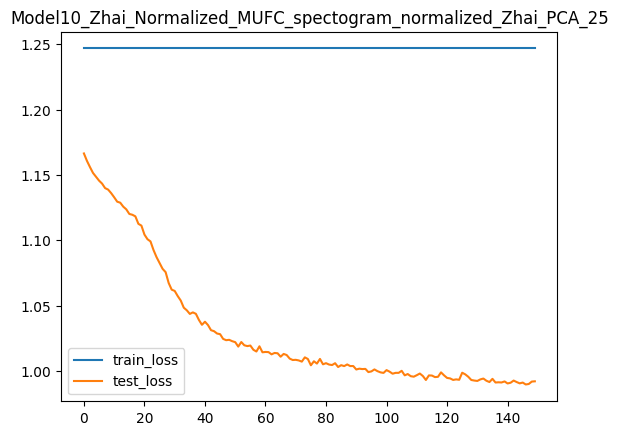

In [20]:
model = Zhai()

mps_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available()  )
model.to(mps_device)

criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = optim.Adam(model.parameters())
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# define the number of epochs
epochs = 150
# define the save address for the model
save_add = dir_manager.dir_dict['user']
# define the name of the model
number_of_classes = 4
model_name = 'Model10_Zhai_Normalized_' + data_name
# train the model
fm.train_model(model,train_dataloader,test_dataloader,optimizer,criterion,epochs,save_add,model_name,number_of_classes,mps_device ,scheduler )


# optimizer = optim.SGD(network.parameters(), lr=learning_rate,
#                       momentum=momentum)
